# Estimating Travel Time Distance Matrices, Access, and Coverage Metrics  

[Irene Farah](https://www.linkedin.com/in/imfarah/),  [Richard Lu](https://www.linkedin.com/in/richard-lu-576874155/), [Caitlyn Tien ](https://www.linkedin.com/in/caitlyn-tien-0b784b161/)  

Center for Spatial Data Science  

University of Chicago  

July 30, 2019

---
This notebook describes the reasoning of the Python modules p2p, BaseModel, and Models which compose the calculation of the algorithm of travel time **matrices** and the estimation of the **metrics**. Please note that this report stipulates the **_parameters_** specified within the estimations so the users can reproduce the calculations.

The purpose of this report is threefold: present the comprehensive methodology for efficiently estimating travel time network distances, generating useful metrics, and illustrating its usage. Specifically, we create an open-source backend infrastructure for estimating travel time network distances (walking, driving, and biking), providing the framework for calculating **access** and **coverage** metrics. These metrics address both the demand and supply of services and goods. On the one hand, the access metrics focuses on the attributes of the **origins** while on the other, the coverage metrics focuses on the attributes from the **destinations** of interest. The two-stage floating catchment area focuses on both origins and destinations.  

Moreover, this framework allows subsetting of the data according to the user's specific questions of interest. These analyses create a powerful tool for supporting stakeholders and researchers in improving transparent decision-making processes and in understanding the issues of unequal spatial access.

In this particular illustration, we analyze health facilities in the city of Chicago. The data is provided from http://makosak.github.io/chihealthaccess/index.html. However, this demo is provided so users can use their own data, by specifying the destinations and the spatial area of interest. 

This notebook provides the overview and logic of the methodology.  

---

## Overview  

Why is this method better?  

This method comprehensively measures access **more efficiently** under an **open-source** and **scalable** framework that runs **offline** for confidentiality sake, compared to the extant state of the art options.  

Generating large shortest path matrices for different transit types is an important tool for spatial data science, but does not currently have a solution that is open source, highly scalable and efficient. Several tools currently exist which fill a similar purpose to this software package. OSRM, Valhalla, Graphhopper and Google Maps, among other services, offer matrix APIs to compute the shortest path distance for datasets but the open-source solutions break down when applied to very large datasets. On the one hand, both Graphhopper and GoogleMaps charge for the service. On the other hand, creating a pgRouting, OSRM, and Valhalla solution does not properly scale. Lastly, OpenTripPlanner does scale, but it is not as fast as p2p.

Each of the above services caps the number of entries in a request at 25-50, meaning that generating a matrix with 500,000 rows requires breaking the original matrix into millions of submatrices and making millions of individual queries. This approach works well for small datasets, but includes substantial overhead which is prohibitive on a large scale. The point to point shortest path algorithm (p2p) can generate matrices between a set of origin and destination points (or origins-origins) in 2 lines of code, efficiently and with a low memory footprint. 

This code generates a driving shortest path matrix for 46,251 blocks in Chicago in ~14 minutes (18 minutes for walking) whereas the same task took > 18 hours using MapZen's Valhalla. For this particular dataset, the mean difference between time values for the driving shortest path matrix and Google Maps' Matrix API is 2 minutes.

**Matrices**  
Specifically, there are two routes the user can take for getting the travel distances: Creating **asymmetric** (nxm) or **symmetric** (nxn) matrices. Symmetric matrices are estimated origin to origin, while asymmetric matrices calculate origin to destination. The user can generate a symmetric distance travel matrix and snap the points of interest to the matrix or create an asymmetric distance matrix that already incorporates origin and destination. The symmetric approach is more appropriate when you need to calculate several scores for the same area and different destinations.

**Metrics**  
After obtaining the distance travel times from origins to destinations (in this case, from the centroids of tracts to the health facilities).
The user can calculate:

- **Access metrics (origin-based)**:
    - **Access Time** to closest destinations (time to nearest neighbor),
    - **Access Count** of nearby destinations within a catchment area (i.e. how many destinations within a 30-minute walk?), 
    - **Access Sum** of an attribute of nearby destinations (within a buffer), 
    - **Access Model** estimates a score from each origin areal unit (tract) to destination (health facilities) (gravity-model), 
    - **Dest Sum** is the sum of a destination within an area (container approach),   
    
    
- **Coverage metrics (destination-based)**:  
    - **Coverage** of the extent at which a facility covers an area (i.e. for each hospital, number of physicians per patient within catchment area of hospital), 
    -  **Two Stage Floating Catchment Area** method is the amount of coverage each areal unit (tract) has access to.  
    For more details on the TSFCA click [here](https://journals.sagepub.com/doi/10.1068/b29120) and for an example use-case of spatial accessibility to primary healthcare click [here](https://saxon.harris.uchicago.edu/accessibility.html). 


The overall infrastructure of the methodology is shown in the following figure:  

<img src="./figures/diagram_code.png" width="1400" title="Optional title">

The workflow first estimates a point to point shortest path [**(p2p)**](./spatial_access/p2p.py) algorithm for creating the travel-time distance matrix by travel mode (walking/driving/biking). First, the code takes the extreme values of the origins and creates a bounding box using the latitude and longitude. Once it generates the bounding box, it queries the network data from OSM, getting all the information from different types of rodes and builds a graph on which p2p can create the travel time matrix.  

Then, it creates a base model infrastructure [**(BaseModel)**](./spatial_access/BaseModel.py) for creating the metrics, using the BaseModel class (parent of Models.py). Specifically, this class allows the user to generate any type of metric, suiting each user's needs. Finally, it creates the models [**(Models)**](./spatial_access/Models.py) for creating aggregate measures of the Access Model, AccessTime, AccessCount, AccessSum, DestinationSum, Coverage Score, and TSFCA. 

This framework provides the user with the flexibility to start at different stages along the process:  

1) Start by creating an asymmetric travel time matrix using the p2p algorithm.  
2) Start by creating a symmetric travel time matrix using the p2p algorithm and then subsetting it to create an asymmetric travel time matrix.  
3) Already has a travel time matrix and wants to make use of the metrics.  

**The folder is organized as follows:**

Under the **docs** folder, the notebooks run through Hyde Park's amenities simple demo, to make sure you have the setup successfully installed: 
* [reqs_install.ipynb](./reqs_install.ipynb)  : This notebook shows the installation requirements in order to run the demos.  
* [simple_demo.ipynb](.//simple_demo.ipynb)  : This notebook shows a simple example which runs the walking matrix and metrics for amenities in Hyde Park, Chicago.  

For a more detailed explanation of the spatial_access packages, the estimation of the matrices, and the calculation of the metrics, please check the following notebooks:
* [0_master.ipynb](./0_master.ipynb)  : These notes explain the structure of spatial_access and the logic behind the estination of matrices and metrics.  
* [1_matrix.ipynb](./1_matrix.ipynb)  : This notebook shows how to run the travel time distance matrices.  It uses the [p2p.py](./scripts/p2p.py) script.  
* [2_access_score.ipynb](./2_access_score.ipynb)  : This notebook shows how to run the access metrics (origin-based) and the specific parameters that might be tweaked depending on the user's interest.  It uses the [BaseModel.py](./spatial_access/BaseModel.py) and [Models.py](./scripts/Models.py) scripts.  
* [3_coverage_score.ipynb](./3_coverage_score.ipynb)  : This notebook shows how to run the coverage metrics (destination-based) and the specific parameters that might be tweaked depending on the user's interest. It uses the [BaseModel.py](./spatial_access/BaseModel.py) and [Models.py](./spatial_access/Models.py) scripts. 
* [4_tsfca.ipynb](./4_tsfca.ipynb)  : This notebook shows how to run a two-stage floating catchment area metric access (origin and destination -based) and the specific parameters that might be tweaked depending on the user's interest.  It uses the [BaseModel.py](./spatial_access/BaseModel.py) and [Models.py](./spatial_access/Models.py) scripts.


The **data** folder contains the input_data needed for the estimation of the metrics under **sources** (for origins) and **destinations** (for destinations). In output_data, the **matrices** folder contains the estimated symmetric and asymmetric matrices. The **modelss** folder contain the results of the models' analyses. Finally, **figures** contain the results of maps and plots calculated during the process. 

---
## Matrices 
(Disregard this section if you already have a travel-time matrix.)

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

**OpenStreetMap structure**  
In order to elucidate how the algorithm for estimating the travel time distance, a brief description of OSM's structure follows.  
OSM's data structure is composed of four elements: nodes, ways, relations, and tags.
Nodes are latitude and longitude coordinates (projected in WGS 84) that represent the map’s features. Ways are a list of nodes that compose the geometry features (i.e. point, line, polygon) within a map, depicting streets, waterways, parks, etc. Relations express the relationship between nodes and ways. Lastly, tags are attached to nodes, mays or relations, storing metadata about the map objects.  

Then, the OpenStreetMap network is downloaded using the area of the previously determined bounding box. The complexity of the network depends on the number of nodes on the generated bounding box (i.e. the area of interest defined by the latitude and longitude coordinates). Therefore, the number of observations should not affect the efficiency of the running times. In order to get the distances from OSM, OSM net calculates the distances of the relations, creating the edges that are queried for the travel time estimation. To estimate these distances, both origin and destination files should be under the same WGS 84 coordinate reference (EPSG:4326).

**P2P (point to point) algorithm**  
In order to calculate the network distance matrix, first, the code extracts the extreme value of latitude/longitude from the origin input table to create a bounding box of the area of interest. The size of the bounding box is increased by 'epsilon', to avoid cutting off the network of datapoints near the boundary of the bounding box. The user can tweak the value of epsilon in **Configs.py**.

P2P uses a k-d tree to match each point in the origin and destination data to its nearest neighbor node in the OSM network, and then finds the Vincenty distance between the two points. Vincenty's formulae estimate the geodesic distance between two points according to an ellipsoidal model of the Earth. (in this case are we using the direct or indirect formula?) Haversine formulas? more accurate? 0.3%>>>  

For the travel time computation between origin and destination, Dijkstra's algorithm considers every possible route and chooses only the fastest route. Therefore, P2P also uses an adjacency list representation for Dijkstra's algorithm to find the shortest path for every node to every other node in the underlying OSM network, but it can skip doing any processing for nodes that do not have an attached origin data point. The advantage of this approach is that it scales to essentially any size dataset; as opposed to the adjacency matrix representation (which can easily exceed the memory of many systems for reasonably large datasets) P2P never loads the entire network into memory at one time, meaning the memory footprint is relatively small. This also means the multithreaded performance of P2P greatly outperforms the singlethreaded performance.  

For every point in the origin dataset to every point in the destination dataset, the base impedence is the cost found using Dijkstra. To the base value we add the 'last mile' inferred impedence from the origin and destination points to their respective nearest nodes, determined by the Euclidean distance and a constant traversal speed. The 'last mile' is figurative; in the City of Chicago, for instance, 75 percent of block centroids were within 100 meters of the nearest OSM node and 95 percent of block centroids were within 200 meters.  

**Islands**  
Some of the units of analysis are classified as islands (disconnected nodes) with OSM. Therefore, Kosaraju's algorithm for directed graph strong connectedness is implemented in p2p (lines 713 - 805 of p2p.py under \_request_network2 function). In graph theory, strong connectivity means that a path exists between any pair of nodes. Thus, we implement Kosaraju's algorithm to identify the disconnected nodes and we eliminate them from the network. 

**Script**  
The p2p.py script runs the point to point (p2p) algorithm and creates the class **TransitMatrix**. The output of p2p is the travel time matrix which is computed in seconds. The **TransitMatrix** unified class run manages all aspects of computing a transit time matrix where matrices can be symmetric or assymetric (as mentioned above). Therefore, load one input file if the user wants a symmetric distance graph, or two for an asymmetric matrix. Particularly, this class account for all the details that entail specifying the speed limits, creating the bounding box for the area of interest in order to run the OSM query and calculate the shortest path matrix.  

**Specifics of P2P parameters**  
Several parameters should be taken into account when calculating the distance network matrix:  
* The **network type** can be determined for walking, biking, or driving.  

* Thresholds can be adjusted and are considered in the calculation of the distance matrix: the **average walking speed** is 5 km/h (3 mph) and the default **average driving speed** is of 40 km/h (25 mph).  This parameter might be specified differently for different populations.  For example, [Chicago](https://www.cityofchicago.org/dam/city/depts/cdot/StreetandSitePlanDesignStandards407.pdf) estimates an average block dimension of 660 feet (200 m) by 330 feet (100 m). These dimensions might change across cities; therefore, the average walking speed of 3 mph estimates that a person, on average, walks a block in 72 to 144 seconds (1.2 - 2.4 min) to walk a block. The default average speeds and speef limits for different OSM type of roads can be found in **Config.py** and specified when running the matrices.   
    
* Also for walking and driving, a **node penalty** of X seconds can also be specified by the user for the number of intersections within the area of analysis. The logic is that having more intersections will increase the travel time due to crossings. However, by doing a time travel calibration between the p2p algorithm and GoogleMaps, there was no need for adding penalities for the city of Chicago for walking and biking, but we added 4 seconds for driving. It can be specified within the **Configs.py** file.
    
* For driving, the network is **directed**, meaning that one way streets are respected and A->B and B->A can have different edge traversal speeds.  

* **Epsilon**: Controls how large to make the network bounding box beyond your dataset. Larger epsilons result in longer computation times, but smaller epsilons result in slightly reduced accuracy at the very edges of the bounding box, especially for driving networks. The default is currently set at 0.05, which seems to balance the two reasonably well. (+/-) 0.02 will result in a large increase/decrease in computation time and accuracy. If too many values are defined as -1, it means that the epsilon is too small. Refer to the epsilon calibration to assess if this value must change and the matrix contains too many -1. The value of -1 is hardcoded in the tmat.h file and is considered as an NaN value of the origins when estimating the metrics.  

* The package allows output of travel time matrices either in **seconds** or in **meters**. The user can specify the output in meters when running the matrix using `use_meters=True`.

<a id='communityanalytics'></a>

---
## Metrics
(Disregard this section if you only care about the travel-time matrix.)

---

#### Origin-based

Across disciplines, accessibility indicators provide a useful measure for a myriad of questions, like analyzing who does and does not live within reach of specific amenities/services or for estimating the spatial mismatch between supply and demand of these services. Thus, we generate an access metrics that indicate the proximity to amenities.

**Access Time**

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

In [ ]:
**Access Count**

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

In [ ]:
**Access Sum**

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

In [ ]:
**Dest Sum**

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

**Access Model**

**_Input Requirements_**  
In order to construct the matrices, the csv table should contain **ID, latitude, longitude** for the origins and destinations.

The score considers the centroids of the areas of analysis as the origin and the amenities as the destination points. It estimates the score by considering a distance decay function, the density and the variety of categories within each area of analysis.    

Depending on the user's preference, the categories can be chosen from the pool of datapoints by creating a dictionary (example shown below). The dictionary will contain the weight that each category will have in the estimation of the score. In this case, a hospital will be categorized as more important than a smaller clinic. However, the weights can be specified according to each user's needs. Moreover, the dictionary categorizes the second nearest clinic as having less weight than the first one. The user may not care for having a greater number of counts per category. The density weights will create a larger score for areas that have a greater variety of categories, creating a more diverse environment. The variety of categories penalizes areas that have the same type of category within an area. Nevertheless, in some cases (like the Chicago health facilities), the repetition of categories should not be penalized because the demand for those services (hospitals) is higher than the service's provision capacity. Therefore, in this example we categorize as equally important the nearest hospital as the fifth nearest hospital. If there is a sixth hospital within a 30 minute buffer of a tract, the score will neglect it since there are only 5 weights specified under 'Hospitals'. As we mentioned before, in this particular case, the dictionary will only take into account the destinations (health facilities) that are within a 30 minute network distance buffer. Therefore, destinations further than 30 minutes from the source (in this case, can be specified in 'upper') will be neglected in the calculation.
As a result, the number of establishments/facilities within a 30 minutes buffer will be aggregated at the areal unit of analysis providing a total count of weights.

**Note**: Please be aware of any mispelling in defining the weights. The score will neglect any category that is mispelled in the definition of the weights.  

In [1]:
#Example of density and variety weights:
dict = {
"Hospitals": [10,10,10,10,10],
"Federally Qualified Health Centers": [8, 7, 6, 5, 4],
"School-Based Health Centers": [7, 7, 6, 6, 5],
"All Free Health Clinics": [5, 5, 5, 4, 4],
"Other Health Providers": [4,3,2,1,1]
}

Then, the distance decay function describes the decreasing intensity of a value as the distance increases. This notebook provides three functions shown below: linear, square root, and logit. However, the user can add any function depending on the amenity's intensity behavior.  

The distance decay functions shown below:

<img src="figures/dd.png" width="1400" title="Optional title">

In order to calculate the access score, each count weight is multiplied by the distance decay function. The distance decay function will weigh each count depending on its relative distance to the source. Therefore, closer destinations will be weighed higher that further away destinations. The figure below whos how the establishments within a buffer are weighted according to the weights dictionary and then weighted by the distance decay function. The image shows how a 10 minute travel time to a hospital is  weighted by the distance decay function, giving it a final score of 9 which is then aggregated to the other scores within a 30 minute buffer. The closest Federally Qualified Health Center is weighted as 8 and the second closest health center is weighted at 7, both multiplied by their corresponding distance decay. Finally, each score is aggregated to generate the final score per area of analysis. In the output, the score is purposely not normalized in order to observe the overall distribution across cities and years, but the standarized and unstandarized results are also included in the output. 

<img src="figures/flow.png" width="1400"  title="Optional title">

**_Specifications_**  

In the **demo prompt**, the user can specify parameters in two different commands:  

**name.AccessModel( ):**  
- network_type ('walk', 'bike', 'drive', 'otp') 
- sources_filename (primary input data)
- destinations_filename (secondary input data)
- source_column_names (dictionary that map column names to expected values)
- dest_column_names (dictionary that map column names to expected values)
- transit_matrix_filename (sources-destination travel time matrix)
- decay_function ('linear', 'root', 'logit', default is 'linear')
**name.calculate():**
- upper_threshold (maximum time considered out of range in seconds, default is 30 minutes, when out of range, score will be zero)
- category_weight_dict (specifies the weights of each facility/establishment defined as dictionary, default dictionary will contain [1,1,1,1,1,1,1,1,1,1] weights.)
- normalize (accepts boolean, default is False and shows only non-normalized results, true shows normalized values.)
- normalize_type ('z_score' or 'minmax', default is 'minmax')

In the **Models**, the user can specify:  The default weights set before as [1,1,1,1,1,1,1,1,1,1] weights, different standarizations, and other modifications to the access score.

GO TO [ACCESS SCORE DEMO](./2_access_score.ipynb) 


----  


**Destination-based**  
The **Coverage** model generates a coverage access which shows the per capita spending available to a specific targeted population. The model focuses on the coverage of the destination, scrutinizing how many people are within a catchment area. Specifically, it takes the total spending of the facility/establishment and divides it by the total population it serves within a buffer (in this case, 30 minutes). In the specifications, the magnitude of the destination is denominated as target. 

<img src="figures/coverage.png" width="600" title="Optional title"  align="center">

 

**_Specifications_**  

**name.Coverage( ):**  
- network_type ('walk', 'bike', 'drive', or 'otp')
- sources_filename (primary input data)
- destinations_filename (secondary input data)
- transit_matrix_filename (origin-destination transit matrix)
        
**name.calculate():**
- upper_threshold (the time (in seconds) in which the origin and destinations are considered to be out of range of each other)

In the **Models**, the user can specify further changed to the coverage score.

GO TO [COVERAGE SCORE DEMO](./3_coverage_score.ipynb) 

----
**Two-Stage Floating Catchment Area**  
The **TSFCA** model generates a coverage access which shows the per capita spending available to a specific targeted population. The model focuses on the coverage of the destination, scrutinizing how many people are within a catchment area. Specifically, it takes the total spending of the facility/establishment and divides it by the total population it serves within a buffer (in this case, 30 minutes). In the specifications, the magnitude of the destination is denominated as target. 

GO TO [TSFCA SCORE DEMO](./4_tsfca.ipynb) 

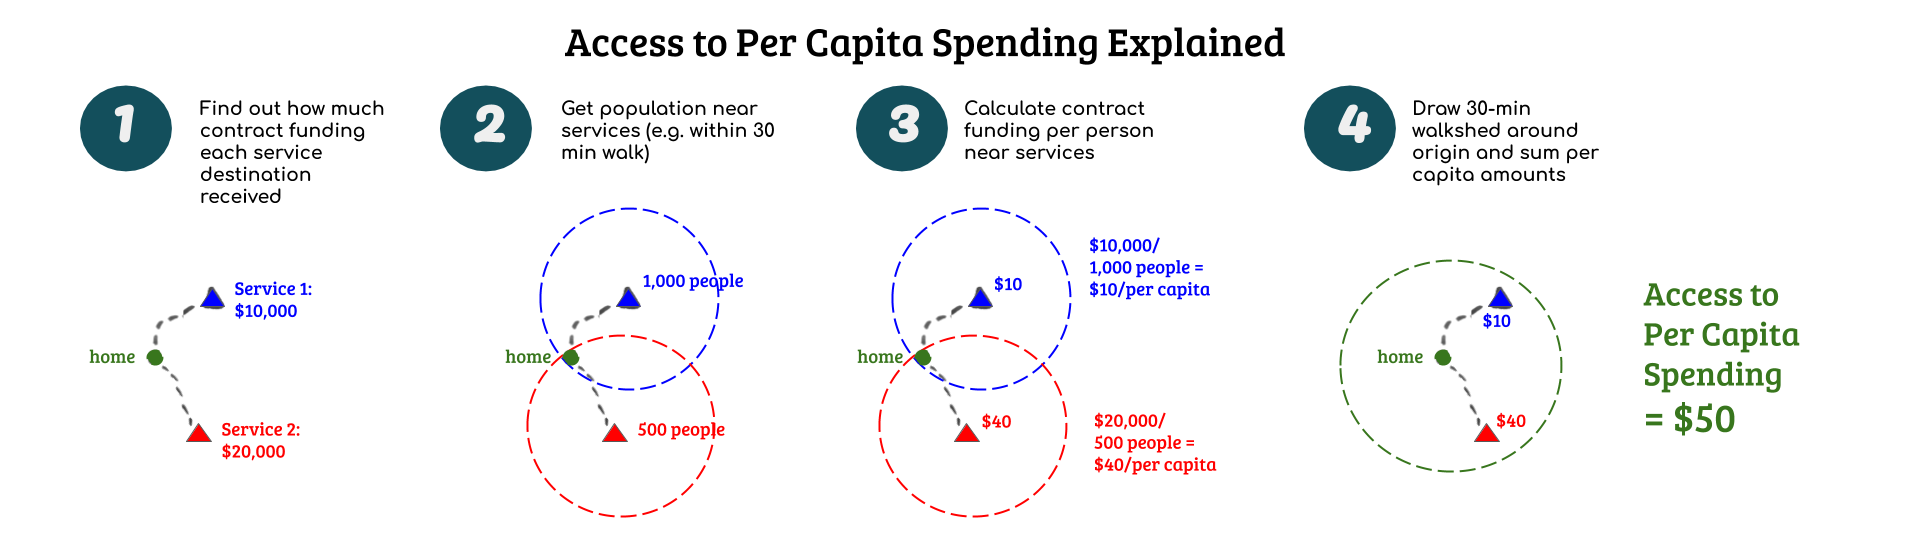

**Final notes**  
The scores can be aggregated at a greater areal unit, as is shown in the demos. The aggregation of the access score is by multiplying all the values at the finer scale, while the aggregation of the coverage score is the sum of the smaller units of analysis. The scripts also contain hard coded empirical cumulative distribution function plots that are also exemplified in the notebooks. The output of the scores is in csv files and can be merged into the origin's or destination's shapefile, mapping out the results of the scores for further analysis.  

The field names in the csv output that contain any symbols will be replaced as underscores in the final output.